<a name="0"></a>
## 0. Setup

In [2]:
# python package to split the data into train, val and test set
!pip install split-folders

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
# check if you access gpu
import splitfolders
import tensorflow as tf
import os


print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.16.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

<a name='1'></a>
## 1. Data Prepration and Visualisation

In [4]:
# Set path to the dataset folder
dataset_path = '/kaggle/input/trashnet/dataset-resized'

# List the contents of the dataset folder
garbage_classes = os.listdir(dataset_path)
print(garbage_classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [5]:
# split data into train, val and test with 70%, 15%, 15% proportions
splitfolders.ratio(dataset_path,seed=1337, output="trash-Splitted", ratio=(0.7, 0.15, 0.15))


Copying files: 2527 files [00:15, 158.56 files/s]


In [6]:
# define paths
train_path = '/kaggle/working/trash-Splitted/train/'
val_path = '/kaggle/working/trash-Splitted/val/'
test_path = '/kaggle/working/trash-Splitted/test/'

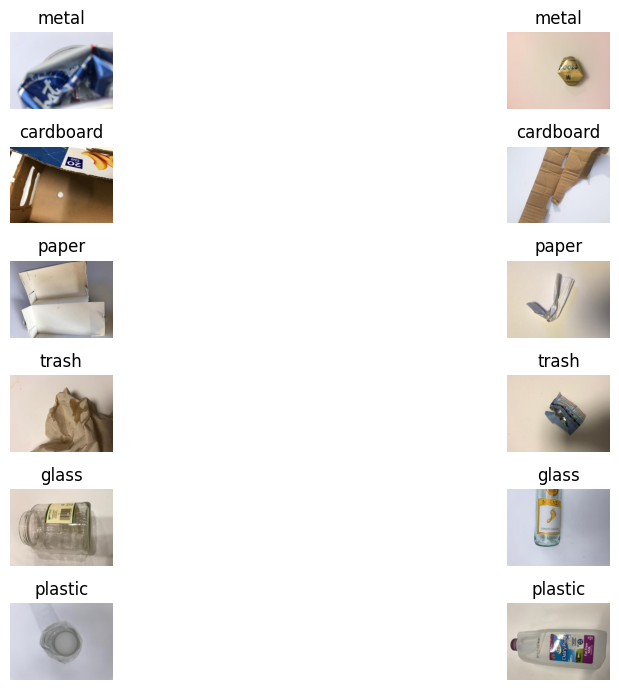

In [7]:
# display a few images
import matplotlib.pyplot as plt
import matplotlib.image as mp
import random
import os


# Select a few random images
images = []
for garbage_class in os.listdir(train_path):
    class_path = os.path.join(train_path, garbage_class)
    image_files = os.listdir(class_path)
    images.extend([os.path.join(class_path, f) for f in random.sample(image_files, 2)])

# Display the images
fig, axes = plt.subplots(len(garbage_classes), 2, figsize=(14,7))
for i, image_path in enumerate(images):
    image = mp.imread(image_path)
    ax = axes[i//2, i%2]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(os.path.basename(os.path.dirname(image_path)))

plt.tight_layout()
plt.show()


In [8]:
# Data preprocessing and augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,  
    fill_mode='nearest'
    )

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

y_train = train_generator.classes
y_val = val_generator.classes
y_test = test_generator.classes

# Get the total number of images in the train, test, and validation sets
total_train = sum(len(files) for _, _, files in os.walk(train_path))
total_test = sum(len(files) for _, _, files in os.walk(test_path))
total_val = sum(len(files) for _, _, files in os.walk(val_path))

print("Total Train:", total_train)
print("Total Test:", total_test)
print("Total Validation:", total_val)

Found 1766 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Total Train: 1766
Total Test: 384
Total Validation: 377


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


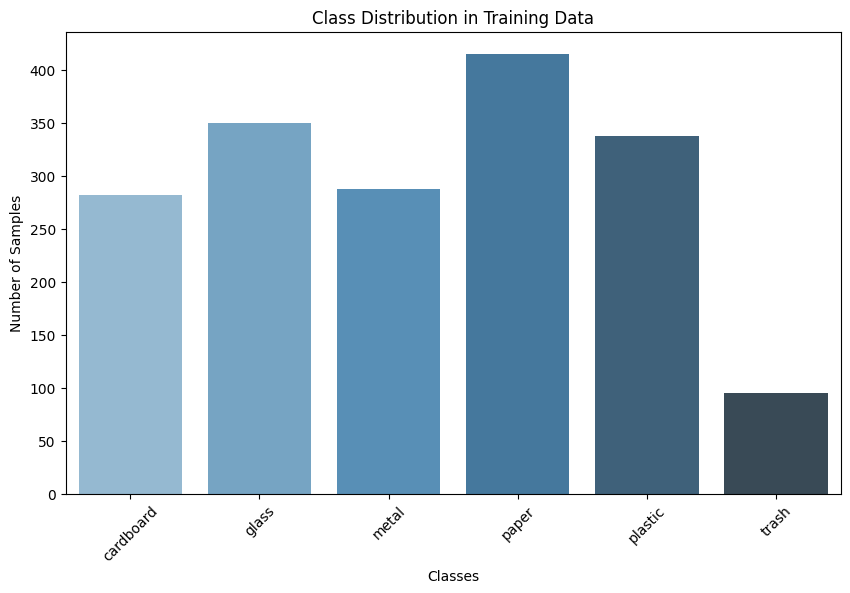

Class 'cardboard': 282 samples
Class 'glass': 350 samples
Class 'metal': 287 samples
Class 'paper': 415 samples
Class 'plastic': 337 samples
Class 'trash': 95 samples
Imbalance Ratio (Max/Min): 4.368421052631579


In [9]:
# Analyse the class inbalance

import numpy as np
import seaborn as sns

class_labels = list(train_generator.class_indices.keys())

# Count the number of instances for each class
class_counts = np.bincount(y_train)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_labels, y=class_counts, palette='Blues_d')
plt.title('Class Distribution in Training Data')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

# Print the counts for each class
for label, count in zip(class_labels, class_counts):
    print(f"Class '{label}': {count} samples")

imbalance_ratio = np.max(class_counts) / np.min(class_counts)
print(f"Imbalance Ratio (Max/Min): {imbalance_ratio}")


<a name='2'></a>
## 2. Training and Finetuning

# 定义CBAM模块。CBAM模块包括两个部分：

* 通道注意力模块：根据通道之间的关系给每个通道加权。
* 空间注意力模块：根据空间上的特征给每个位置加权。


In [10]:
import tensorflow as tf
from tensorflow.keras import layers

# Channel Attention Module (CAM)
class ChannelAttention(layers.Layer):
    def __init__(self, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()
        self.dense1 = layers.Dense(input_shape[-1] // self.reduction_ratio, activation='relu', use_bias=False)
        self.dense2 = layers.Dense(input_shape[-1], activation='sigmoid', use_bias=False)

    def call(self, inputs):
        avg_out = self.avg_pool(inputs)
        max_out = self.max_pool(inputs)
        avg_out = tf.expand_dims(tf.expand_dims(avg_out, 1), 1)
        max_out = tf.expand_dims(tf.expand_dims(max_out, 1), 1)

        avg_out = self.dense1(avg_out)
        max_out = self.dense1(max_out)

        avg_out = self.dense2(avg_out)
        max_out = self.dense2(max_out)

        out = avg_out + max_out
        return inputs * out  # Element-wise multiplication

# Spatial Attention Module (SAM)
class SpatialAttention(layers.Layer):
    def __init__(self):
        super(SpatialAttention, self).__init__()

    def build(self, input_shape):
        self.conv = layers.Conv2D(1, (7, 7), strides=1, padding='same', activation='sigmoid', use_bias=False)

    def call(self, inputs):
        avg_out = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_out = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_out, max_out], axis=-1)
        out = self.conv(concat)
        return inputs * out  # Element-wise multiplication

# CBAM (Channel + Spatial Attention)
class CBAM(layers.Layer):
    def __init__(self, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(reduction_ratio)
        self.spatial_attention = SpatialAttention()

    def call(self, inputs):
        x = self.channel_attention(inputs)
        x = self.spatial_attention(x)
        return x


In [11]:
# Load the pre-trained ResNet50 model
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Add CBAM after each block in the ResNet50 model
x = base_model.output
x = CBAM()(x)  # Apply CBAM to the output of the base model
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(6, activation='softmax')(x)  # 6 classes for TrashNet

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# Print the model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,124,392 (92.03 MB)

 Trainable params: 24,071,272 (91.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:

from sklearn.utils.class_weight import compute_class_weight

# compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Compute class weights, helps with class inbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# early stopping of the training process with patience=3
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=7,restore_best_weights=True)

# reduces the learning rate by a 0.5 every 10 epochs, this might be unused as the training could stop earlier
def step_decay(epoch):
    initial_lr = 0.0001 # start with a lower learning rate than default 0.001 as the loss starts very large
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop ** ((epoch) // epochs_drop))
    return lr

# Callback for learning rate scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay)

# train the model
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=val_generator,
                    steps_per_epoch=total_train // batch_size,
                    validation_steps=total_val // batch_size,
                    class_weight=class_weight_dict,
                    callbacks=[callbacks, lr_scheduler]
                    )


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732210736.282562     132 service.cc:145] XLA service 0x79ea0c0037f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732210736.282629     132 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732210736.282635     132 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732210763.167586     132 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_26', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1732210763.211

 4/55 ━━━━━━━━━━━━━━━━━━━━ 5:57 7s/step - accuracy: 0.1002 - loss: 1.7865  

I0000 00:00:1732210784.401994     132 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_48', 168 bytes spill stores, 168 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 28 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_22', 20 bytes spill stores, 20 bytes spill loads



55/55 ━━━━━━━━━━━━━━━━━━━━ 101s 799ms/step - accuracy: 0.2202 - loss: 1.7832 - val_accuracy: 0.3892 - val_loss: 1.8104 - learning_rate: 1.0000e-04
Epoch 2/30
 1/55 ━━━━━━━━━━━━━━━━━━━━ 15s 283ms/step - accuracy: 0.4062 - loss: 1.4968

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4062 - loss: 1.4968 - val_accuracy: 0.1200 - val_loss: 2.1479 - learning_rate: 1.0000e-04
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 357ms/step - accuracy: 0.3711 - loss: 1.5061 - val_accuracy: 0.4602 - val_loss: 2.1916 - learning_rate: 1.0000e-04
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 1.1765 - val_accuracy: 0.2800 - val_loss: 4.3741 - learning_rate: 1.0000e-04
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 363ms/step - accuracy: 0.6732 - loss: 1.0278 - val_accuracy: 0.7330 - val_loss: 1.0062 - learning_rate: 1.0000e-04
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.5823 - val_accuracy: 0.6800 - val_loss: 1.5961 - learning_rate: 1.0000e-04
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 358ms/step - accuracy: 0.7616 - loss: 0.7492 - val_accuracy: 0.7670 - val_loss: 0.6967 - learning_rate: 1.0000e-04
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 

In [13]:
# Model evaluation
# this is the average accuracy over batches of test data
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy:', accuracy)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9022 - loss: 0.3812
Test accuracy: 0.9036458134651184


In [14]:
# Fine-tune the last 10 layers for 10 more epochs
model.trainable = True

for layer in model.layers[:-10]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 438ms/step - accuracy: 0.9616 - loss: 0.1210 - val_accuracy: 0.8859 - val_loss: 0.3672
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 324ms/step - accuracy: 0.9661 - loss: 0.1116 - val_accuracy: 0.8859 - val_loss: 0.3485
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 322ms/step - accuracy: 0.9671 - loss: 0.1108 - val_accuracy: 0.8939 - val_loss: 0.3464
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - accuracy: 0.9599 - loss: 0.1148 - val_accuracy: 0.8966 - val_loss: 0.3407
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - accuracy: 0.9714 - loss: 0.0952 - val_accuracy: 0.8912 - val_loss: 0.3383
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 320ms/step - accuracy: 0.9706 - loss: 0.0932 - val_accuracy: 0.8966 - val_loss: 0.3443
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step - accuracy: 0.9650 - loss: 0.1102 - val_accuracy: 0.8992 - val_loss: 0.3424
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - accuracy: 0.9575 - loss: 0.1069 - val_accu

<a name='3'></a>
## 3. Evaluation

In [15]:
# Model evaluation after finetuning
# this is the average accuracy over batches of test data
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy:', accuracy)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9213 - loss: 0.3135
Test accuracy: 0.9166666865348816


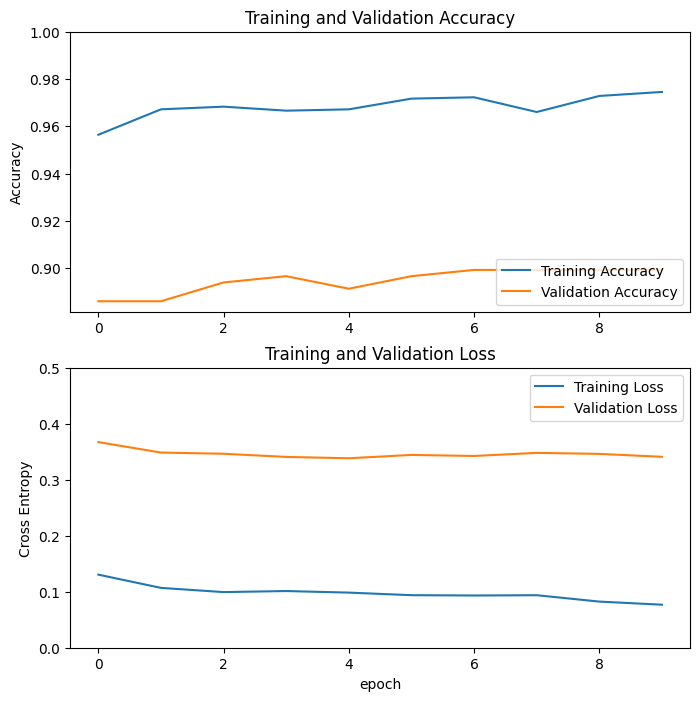

In [16]:
# plot loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
# Calculate precision, recall and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Predict on test data

y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

# calculate precision, recall and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print('all the metrics below are the weighted average across all classes (weighing by the number of instances).')
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)



12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step
all the metrics below are the weighted average across all classes (weighing by the number of instances).
Precision: 0.9170918677957386
Recall: 0.9166666666666666
F1 score: 0.9165067731097629


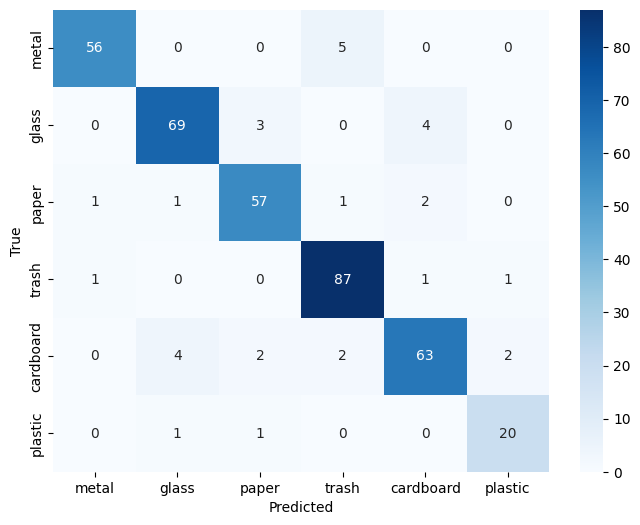

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=garbage_classes, yticklabels=garbage_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [19]:
# calculate accuracy from confusion matrix, compare this value with the one given during inference
cm_accuracy = np.trace(cm)/len(y_true)
print('Accuracy:', cm_accuracy)

Accuracy: 0.9166666666666666


In [22]:


# Save the model to the specified path in Keras format
model_save_path = '/kaggle/working/different_path/trashnet_model.h5'
model.save(model_save_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image: glass72.jpg | Predicted Class: glass | Confidence: 1.00


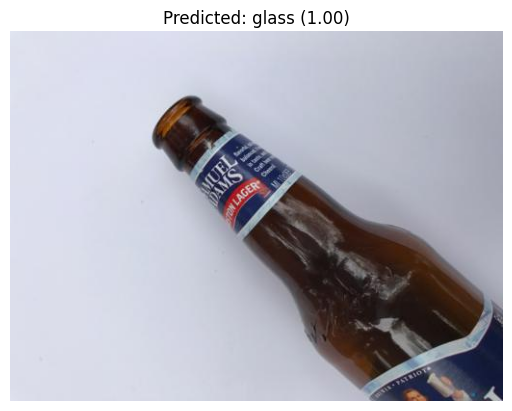

In [29]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score

# Define custom attention layers
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.max_pool = tf.keras.layers.GlobalMaxPooling2D()
        self.dense1 = tf.keras.layers.Dense(input_shape[-1] // self.reduction_ratio, activation='relu', use_bias=False)
        self.dense2 = tf.keras.layers.Dense(input_shape[-1], activation='sigmoid', use_bias=False)

    def call(self, inputs):
        avg_out = self.avg_pool(inputs)
        max_out = self.max_pool(inputs)
        avg_out = tf.expand_dims(tf.expand_dims(avg_out, 1), 1)
        max_out = tf.expand_dims(tf.expand_dims(max_out, 1), 1)

        avg_out = self.dense1(avg_out)
        max_out = self.dense1(max_out)

        avg_out = self.dense2(avg_out)
        max_out = self.dense2(max_out)

        out = avg_out + max_out
        return inputs * out  # Element-wise multiplication

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv = tf.keras.layers.Conv2D(1, (7, 7), strides=1, padding='same', activation='sigmoid', use_bias=False)

    def call(self, inputs):
        avg_out = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_out = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_out, max_out], axis=-1)
        out = self.conv(concat)
        return inputs * out  # Element-wise multiplication

class CBAM(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.channel_attention = ChannelAttention(reduction_ratio)
        self.spatial_attention = SpatialAttention()

    def call(self, inputs):
        x = self.channel_attention(inputs)
        x = self.spatial_attention(x)
        return x

# Define the path to the trained model
model_path = '/kaggle/working/different_path/trashnet_model.h5'

# Check if the model file exists before loading
if not os.path.exists(model_path):
    raise FileNotFoundError(f"The specified model file does not exist: {model_path}")

# Load the trained model with custom CBAM layer
custom_objects = {
    'CBAM': CBAM,
    'ChannelAttention': ChannelAttention,
    'SpatialAttention': SpatialAttention
}

model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# Define a function to load and preprocess a single image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array

# Define a function to predict the class of a given image
def predict_image_class(img_path, model, class_labels):
    preprocessed_img = load_and_preprocess_image(img_path)
    predictions = model.predict(preprocessed_img)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence_score = predictions[0][predicted_class]
    return class_labels[predicted_class], confidence_score

# Define a function to test a single image from the test set and display the result
def test_single_image(model, test_image_folder, class_labels):
    # List all image files in the test_image_folder
    image_paths = []
    for root, dirs, files in os.walk(test_image_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))

    # Select a random image from the test set
    if not image_paths:
        raise FileNotFoundError("No images found in the test set folder.")
    img_path = np.random.choice(image_paths)

    # Predict the class and display the result
    predicted_class, confidence = predict_image_class(img_path, model, class_labels)
    print(f"Image: {os.path.basename(img_path)} | Predicted Class: {predicted_class} | Confidence: {confidence:.2f}")
    
    # Display the image
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class} ({confidence:.2f})')
    plt.show()

# Test module usage
if __name__ == '__main__':
    # Set the path to a folder containing images for testing
    test_image_folder = '/kaggle/working/trash-Splitted/test'
    # Define the class labels used in training
    class_labels = [
        'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'
    ]
    # Test a single image from the test set
    test_single_image(model, test_image_folder, class_labels)


